# Connect To Google Drive 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **REFERENCES**


*   https://www.sciencedirect.com/science/article/pii/B9780128190616000069
*   https://sci-hub.tw/https://doi.org/10.3109/03091909309006329
*   http://cinc.org/archives/2003/pdf/323.pdf
*   https://ieeexplore.ieee.org/document/5738061
*   https://classeval.wordpress.com/introduction/basic-evaluation-measures/







# Pre-Load Library

In [2]:
import os
import librosa
import numpy as np
import pywt
from scipy import signal
import seaborn as sns
import matplotlib.pyplot as plt   

In [3]:
import tensorflow as tf, tensorflow.keras.backend as K
import tensorflow_addons as tfa
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

# Prepare Dataset

IN THIS SECTION, THIS IS A FILE DIRECTORY REGARDED TO A DATASET THAT HAS BEEN TRANSFORM INTO PRINCIPAL COMPONENTS ANALYSIS MATRICES

In [4]:
dirlabel_t="/content/drive/My Drive/DataSetSuaraJantungPhysionet/Dataset/LABELTRAIN.npy"
dirlabel_v="/content/drive/My Drive/DataSetSuaraJantungPhysionet/Dataset/LABELVAL.npy"

#Training and Validation
matrices_datasetTV=['/content/drive/My Drive/DataSetSuaraJantungPhysionet/Dataset/eigenDataTrain100percent.npy',
                    '/content/drive/My Drive/DataSetSuaraJantungPhysionet/Dataset/eigenDataTrain75percent.npy',
                    '/content/drive/My Drive/DataSetSuaraJantungPhysionet/Dataset/eigenDataTrain50percent.npy',
                    '/content/drive/My Drive/DataSetSuaraJantungPhysionet/Dataset/eigenDataTrain25percent.npy'] 

#test Set
matrices_datasetTest=['/content/drive/My Drive/DataSetSuaraJantungPhysionet/Dataset/eigenDataValid100percent.npy',
                      '/content/drive/My Drive/DataSetSuaraJantungPhysionet/Dataset/eigenDataValid75percent.npy',
                      '/content/drive/My Drive/DataSetSuaraJantungPhysionet/Dataset/eigenDataValid50percent.npy',
                      '/content/drive/My Drive/DataSetSuaraJantungPhysionet/Dataset/eigenDataValid25percent.npy'] 


THIS IS AN INDEX MATRICES FOR WHAT DIMENSION DATASET THAT WOULD BE USED

In [5]:
opsi=0 #pilih persentasi feature dataset (misal, opsi= 100% feature penting)

IN THIS CODE, WHERE PREPARATION OF DATASET BEGIN. SPLITTING THE DATASET AND RESHAPE THE SHAPE OF MATRICES TO BE FITTED TO NEURAL NETWORK

In [6]:
from sklearn.model_selection import train_test_split

trainvalSet=np.load(matrices_datasetTV[opsi]) #training dan validasi (akan di split nanti)
testSet=np.load(matrices_datasetTest[opsi]) #menjadi test set

trainvalSet=np.reshape(trainvalSet,(-1,trainvalSet.shape[1],trainvalSet.shape[2],1))
testSet=np.reshape(testSet,(-1,testSet.shape[1],testSet.shape[2],1))

label_train=np.load(dirlabel_t)
label_test=np.load(dirlabel_v)


X_train, validation, y_train, label_v = train_test_split(trainvalSet, label_train, test_size=0.2,random_state=42)

print(X_train.shape,validation.shape)

#To see the distribution data of each classes
print(np.array(np.where(y_train == 0)).shape,np.array(np.where(y_train == 1)).shape)
print(np.array(np.where(label_v == 0)).shape,np.array(np.where(label_v == 1)).shape)

(2592, 130, 130, 1) (648, 130, 130, 1)
(1, 2064) (1, 528)
(1, 511) (1, 137)


# Utility Function

In [7]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Tuning Hyperparameter

In [8]:
dataSize=[trainvalSet.shape[1],trainvalSet.shape[2]]
EPOCHS=13
BATCH_SIZE = 32

CLASSES=['Not Normal','Normal']       

In [10]:
#learning rate scheduler

LR_START = 0.0001
LR_MAX =  0.000015
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 7
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = np.random.random_sample() * LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [11]:
pretrained_model=tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, weights=None,  input_shape=[*dataSize, 1])
pretrained_model.trainable = True # False = transfer learning, True = fine-tuning      

model = tf.keras.Sequential([
          pretrained_model,
          tf.keras.layers.Dropout(0.15),
          tf.keras.layers.GlobalAveragePooling2D(),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(1, activation='sigmoid')
      ])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 5, 5, 2048)        23558528  
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,560,577
Trainable params: 23,515,137
Non-trainable params: 45,440
_________________________________________________________________


In [12]:
radam = tfa.optimizers.RectifiedAdam()

model.compile(
    # optimizer='adam',
    optimizer= tfa.optimizers.Lookahead(radam, sync_period=4, slow_step_size=0.35),
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

# Training

In [13]:

class_weight = {0: 0.70,
                1: 1.955}

history=model.fit( x=X_train,y=y_train,validation_data=(validation,label_v),
          epochs=EPOCHS,callbacks=[lr_callback],
          class_weight=class_weight,
          use_multiprocessing=False
          )

Epoch 1/13

Epoch 00001: LearningRateScheduler reducing learning rate to 1.866874820701082e-05.
81/81 [==============================] - 65s 203ms/step - loss: 0.7138 - accuracy: 0.3527 - val_loss: 0.7253 - val_accuracy: 0.2160
Epoch 2/13

Epoch 00002: LearningRateScheduler reducing learning rate to 2.669161606950121e-06.
81/81 [==============================] - 15s 189ms/step - loss: 0.5973 - accuracy: 0.7022 - val_loss: 0.6314 - val_accuracy: 0.7469
Epoch 3/13

Epoch 00003: LearningRateScheduler reducing learning rate to 7.150832206231348e-05.
81/81 [==============================] - 16s 192ms/step - loss: 0.5037 - accuracy: 0.7605 - val_loss: 0.4679 - val_accuracy: 0.8256
Epoch 4/13

Epoch 00004: LearningRateScheduler reducing learning rate to 9.722433197056137e-05.
81/81 [==============================] - 16s 193ms/step - loss: 0.4025 - accuracy: 0.8546 - val_loss: 0.3856 - val_accuracy: 0.8503
Epoch 5/13

Epoch 00005: LearningRateScheduler reducing learning rate to 1.5e-05.
81/81 

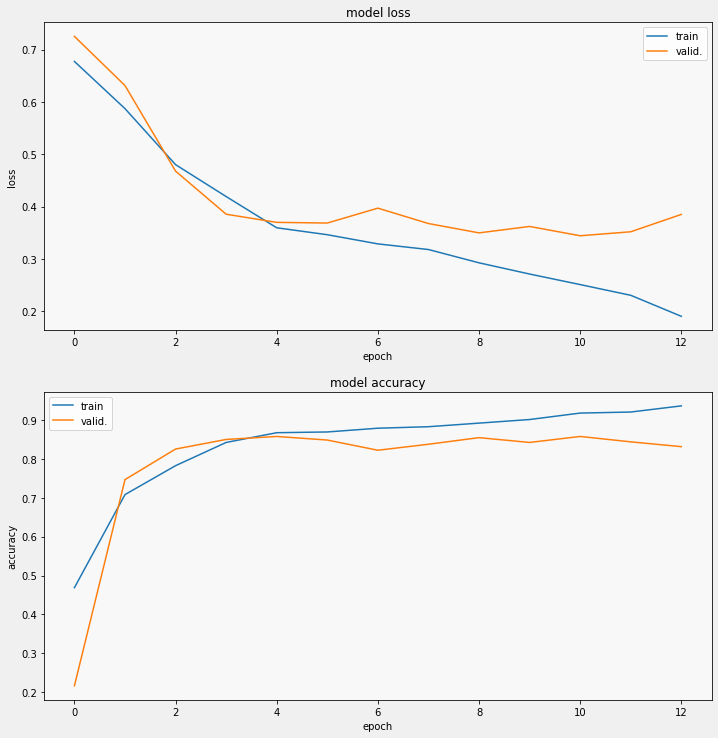

In [14]:


display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)



# Metric Model

In [15]:
"""Confusion Matrix, For Model Benchmark"""
yPredict = model.predict_classes(testSet)
yPredict=np.transpose(yPredict)
yPredict=yPredict.flatten()

print("Predicted Label: ",yPredict[:20])
print("Correct Label: ",label_test[:20])

cmatrix= confusion_matrix(label_test, yPredict, labels=[0,1])
print(cmatrix)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Predicted Label:  [1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 0 0 1 1]
Correct Label:  [1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 0 1]
[[136  14]
 [ 19 132]]


In [16]:
#metric
score = f1_score(label_test, yPredict, labels=[0,1], average='macro')
precision = precision_score(label_test, yPredict,  labels=[0,1], average='macro')
recall = recall_score(label_test, yPredict,  labels=[0,1], average='macro')
cmat = (cmatrix.T / cmatrix.sum(axis=1)).T # normalized

print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

f1 score: 0.890, precision: 0.891, recall: 0.890


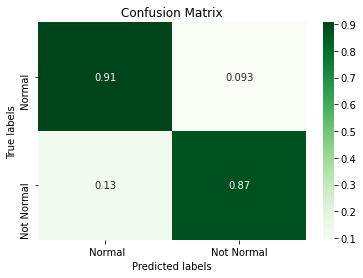

In [18]:
#visual confusion matrix
  

ax= plt.subplot()
sns.heatmap(cmat,cmap='Greens', annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([' Normal', 'Not Normal']); 
ax.yaxis.set_ticklabels([' Normal', 'Not Normal']);

# Evaluate Model Using Test Data

In [19]:
#0  normal(-1)
#1 	not normal(1)
Xnew=[]
Xnew = model.predict_classes(testSet)
for i in range(len(Xnew)):
	print("X=%s, Predicted=%s" % (label_test[i], Xnew[i]))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


X=1, Predicted=[1]
X=1, Predicted=[1]
X=1, Predicted=[1]
X=1, Predicted=[1]
X=1, Predicted=[1]
X=1, Predicted=[1]
X=0, Predicted=[0]
X=1, Predicted=[1]
X=0, Predicted=[0]
X=1, Predicted=[1]
X=0, Predicted=[0]
X=0, Predicted=[0]
X=1, Predicted=[1]
X=1, Predicted=[1]
X=1, Predicted=[1]
X=0, Predicted=[1]
X=1, Predicted=[0]
X=1, Predicted=[0]
X=0, Predicted=[1]
X=1, Predicted=[1]
X=1, Predicted=[1]
X=1, Predicted=[1]
X=1, Predicted=[1]
X=1, Predicted=[1]
X=0, Predicted=[0]
X=1, Predicted=[1]
X=0, Predicted=[0]
X=0, Predicted=[0]
X=0, Predicted=[0]
X=1, Predicted=[1]
X=1, Predicted=[0]
X=0, Predicted=[1]
X=1, Predicted=[0]
X=1, Predicted=[1]
X=0, Predicted=[0]
X=1, Predicted=[1]
X=1, Predicted=[1]
X=0, Predicted=[1]
X=1, Predicted=[1]
X=1, Predicted=[1]
X=1, Predicted=[1]
X=1, Predicted=[1]
X=1, Predicted=[1]
X=1, Predicted=[1]
X=1, Predicted=[0]
X=1, Predicted=[1]
X=1, Predicted=[1]
X=1, Predicted=[1]
X=0, Predicted=[1]
X=0, Predicted=[0]
X=1, Predicted=[1]
X=1, Predicted=[1]
X=0, Predict